# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import time
import random

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50V2, ResNet50
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
category = 'Induk aksara'

train_dir = f"../dataset/preprocessed/{category}/train"
val_dir = f"../dataset/preprocessed/{category}/val"
test_dir = f"../dataset/preprocessed/{category}/test"

IMG_SIZE = (224,224)
BATCH_SIZE = 32
SEED = 42

datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

datagen_val = ImageDataGenerator(rescale=1./255)

datagen_test = ImageDataGenerator(rescale=1./255)

print('\nTrain Data:')
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True)

print('\nValidation Data:')
generator_val = datagen_val.flow_from_directory(directory=val_dir,
                                                target_size=IMG_SIZE,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False)

print('\nTesting Data:')
generator_test = datagen_test.flow_from_directory(directory=test_dir, 
                                                  target_size=IMG_SIZE, 
                                                  batch_size=BATCH_SIZE, 
                                                  shuffle=False)


Train Data:
Found 560 images belonging to 20 classes.

Validation Data:
Found 160 images belonging to 20 classes.

Testing Data:
Found 80 images belonging to 20 classes.


In [3]:
classes_train = generator_train.classes
classes_val = generator_val.classes
classes_test = generator_test.classes

In [4]:
class_names = list(generator_train.class_indices.keys())
num_classes = generator_train.num_classes
print('Classes Names:', class_names)

Classes Names: ['A', 'BA', 'CA', 'DA', 'GA', 'GHA', 'HA', 'JA', 'KA', 'LA', 'MA', 'NA', 'NGA', 'NYA', 'PA', 'RA', 'SA', 'TA', 'WA', 'YA']


# Helper Functions

In [5]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [6]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

In [7]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [8]:
def print_layer_trainable(model):
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [9]:
def plot_history(history):
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.grid()
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.xticks(np.arange(0, EPOCHS, 2))
    plt.legend(['Train Accuracy', 'Validation Accuracy'])

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid()
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.xticks(np.arange(0, EPOCHS, 2))
    plt.legend(['Train Loss', 'Validation Loss'])

    plt.show()

In [10]:
def plot_confusion_matrix(actual_classes, predicted_classes):
    # Hitung confusion matrix antara label kelas asli dan label kelas prediksi
    conf_matrix = confusion_matrix(actual_classes, predicted_classes)

    # Plot confusion matrix dalam bentuk heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Hitung classification report
    report = classification_report(actual_classes, predicted_classes, target_names=class_names)

    # Tampilkan classification report
    print("Classification Report:")
    print(report)

In [11]:
def example_success(actual_classes, predicted_classes):
    
    # Boolean array whether the predicted class is incorrect.
    correct = (predicted_classes == actual_classes)

    # Get the file-paths for images that were correctly classified.
    image_paths = np.array(image_paths_test)[correct]

    # Randomly .
    i = random.randint(0, len(image_paths)-9)
    j = i + 9

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[i:j])
    
    # # Get the predicted classes for those images.
    class_pred = predicted_classes[correct] 

    # Get the true classes for those images.
    cls_true = actual_classes[correct]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[i:j],
                cls_pred=class_pred[i:j])

In [12]:
def example_errors(actual_classes, predicted_classes):
    # Boolean array whether the predicted class is incorrect.
    incorrect = (predicted_classes != actual_classes)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # # Get the predicted classes for those images.
    class_pred = predicted_classes[incorrect] 

    # Get the true classes for those images.
    cls_true = actual_classes[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=class_pred[0:9])
    
    predict_paths = []
    random.seed(42)
    for cls in class_pred:
        class_dir = os.path.join(test_dir, class_names[cls])
        new_path = class_dir.replace("/test", "/train")
        predict_path = random.choice([os.path.join(new_path, file) for file in os.listdir(new_path) if file.endswith('.png') and 'aug' not in file])
        predict_paths.append(predict_path)
    predict_img= load_images(predict_paths)
    print(len(predict_img), len(class_pred))

    plot_images(images=predict_img, cls_true=class_pred, smooth=True)

In [13]:
def grid_search_results(gs):
    print(f"Fitting {gs.n_splits_} folds for each of {len(gs.cv_results_['params'])} candidates, totalling {len(gs.cv_results_['params']) * gs.n_splits_} fits")
    for i, param in enumerate(gs.cv_results_['params']):
        print(f"Parameters: {param}")
        for j in range(gs.n_splits_):
            accuracy = gs.cv_results_[f'split{j}_test_accuracy'][i]
            neg_log_loss = gs.cv_results_[f'split{j}_test_neg_log_loss'][i]
            print(f"[CV {j+1}/{gs.n_splits_}] accuracy: (test={accuracy:.3f}) log_loss: (test={neg_log_loss*-1:.3f})")
        print()
    print('Best Parameter:', gs.best_params_, 'with average accuracy score:', gs.best_score_.round(4))

In [14]:
import csv

csv_file = f"../benchmark_result/{category}/results.csv"

def read_existing_results(csv_file):
    results = {}
    if os.path.isfile(csv_file):
        with open(csv_file, mode='r', newline='') as file:
            reader = csv.reader(file, delimiter=';')
            next(reader)  # Skip the header
            for row in reader:
                model_name = row[0]
                results[model_name] = [float(row[1]), float(row[2]), float(row[3]), float(row[4]), float(row[5])]
    return results

def save_results(accuracy_results):
    # Read existing results
    existing_results = read_existing_results(csv_file)

    # Update existing results with new data
    existing_results.update(accuracy_results)

    # Write the updated results to the CSV file
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        header = ['Model Name', 'Train Accuracy', 'Validation Accuracy', 'Test Accuracy', 'Training Time', 'Predicting Time']
        writer.writerow(header)
        for model_name, results in existing_results.items():
            writer.writerow([model_name] + results)

    print(f'Data has been saved to {csv_file}')

# Plot Sample of Images

In [15]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_val = path_join(val_dir, generator_val.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

train_images = load_images(image_paths_train)
val_images = load_images(image_paths_val)
test_images = load_images(image_paths_test)

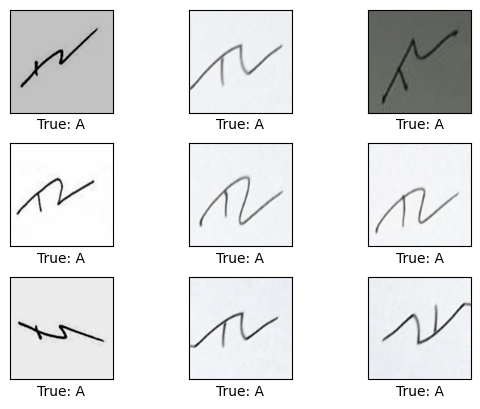

In [16]:
# Plot the images and labels using our helper-function above.
plot_images(images=train_images, cls_true=classes_train, smooth=True)

# Modeling Experiment

In [17]:
accuracy_results  = {}

## VGG16

In [18]:
vgg16_pretrained = VGG16(include_top=False, 
                         input_shape=(224, 224, 3), 
                         weights='imagenet')

vgg16_pretrained.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Build a Model

In [19]:
m = vgg16_pretrained.output
m = Flatten()(m)
m = Dense(4096, activation='relu', name='fc1')(m)
m = Dense(4096, activation='relu', name='fc2')(m)
predictions = Dense(num_classes, activation='softmax', name='prediction')(m)

vgg16_m = Model(inputs=vgg16_pretrained.input, outputs=predictions, name="vgg16")

vgg16_m.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
print_layer_trainable(vgg16_m)

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool
True:	flatten
True:	fc1
True:	fc2
True:	prediction


In [21]:
for layer in vgg16_m.layers:
    layer.trainable = False
    if layer.name.startswith('block5_pool'):
        break

vgg16_m.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
print_layer_trainable(vgg16_m)

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool
True:	flatten
True:	fc1
True:	fc2
True:	prediction


### Set Paramater Values

In [23]:
OPTIMIZER=Adam(learning_rate=0.001)
LOSS='categorical_crossentropy'
METRICS=['categorical_accuracy']

STEPS_PER_EPOCH = generator_train.n/BATCH_SIZE
VALIDATION_STEPS = generator_val.n/BATCH_SIZE
EPOCHS = 30

model_name = "vgg16_m"
filepath = f'../saved_models/{category}/{model_name}.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=2, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_categorical_accuracy', patience=7, verbose=1)

CALLBACKS = [reduce_lr, checkpoint, early_stop]

### Training the Model

In [24]:
vgg16_m.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=METRICS)

start_time = time.time()
h_vgg16 = vgg16_m.fit_generator(generator_train,
                                epochs=EPOCHS, 
                                steps_per_epoch=STEPS_PER_EPOCH, 
                                validation_data=generator_val, 
                                validation_steps=VALIDATION_STEPS, 
                                callbacks=CALLBACKS)
end_time = time.time()

Epoch 1/30
17/17 [==============================] - 15s 492ms/step - loss: 12.3085 - categorical_accuracy: 0.0464 - val_loss: 3.0973 - val_categorical_accuracy: 0.0562 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - 6s 331ms/step - loss: 3.0107 - categorical_accuracy: 0.0804 - val_loss: 2.8512 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - 6s 336ms/step - loss: 2.6575 - categorical_accuracy: 0.1571 - val_loss: 2.3187 - val_categorical_accuracy: 0.1813 - lr: 0.0010
Epoch 4/30
17/17 [==============================] - 5s 306ms/step - loss: 2.1559 - categorical_accuracy: 0.3071 - val_loss: 1.9458 - val_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 5/30
17/17 [==============================] - 5s 298ms/step - loss: 1.6741 - categorical_accuracy: 0.4464 - val_loss: 1.3113 - val_categorical_accuracy: 0.5562 - lr: 0.0010
Epoch 6/30
17/17 [==============================] - 5s 305ms/step - loss: 1.2925 - categorical_accuracy

### Model Evaluation

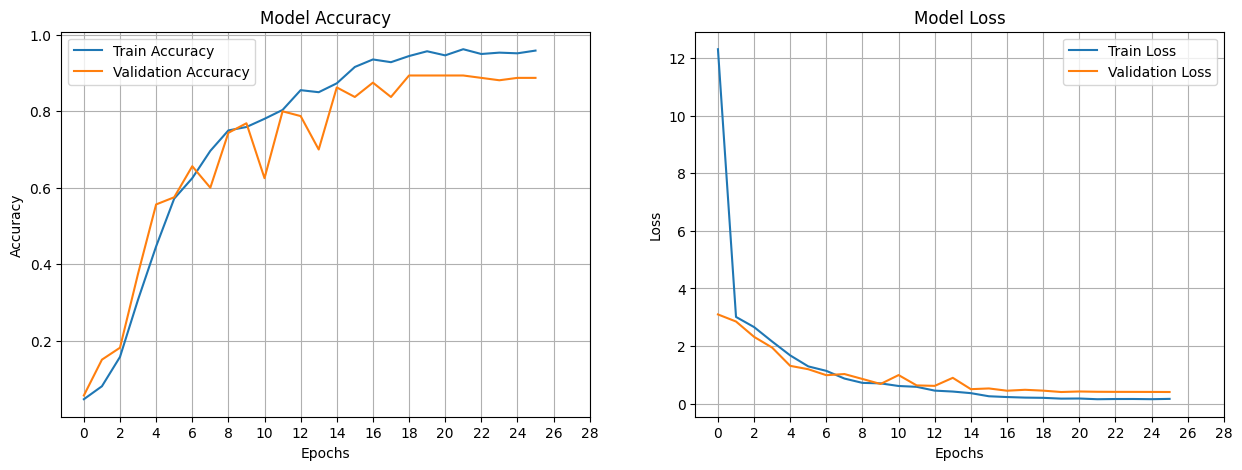

In [25]:
plot_history(h_vgg16)

In [26]:
model_name = 'vgg16_m'
model_path = f"../saved_models/{category}/{model_name}.hdf5"
vgg16_m= load_model(model_path)

train_loss, train_accuracy = vgg16_m.evaluate_generator(generator_train)
print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = vgg16_m.evaluate_generator(generator_val)
print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.18548385798931122
Training Accuracy: 0.9482142925262451
------------------------------------------------
Validation Loss: 0.45022520422935486
Validation Accuracy: 0.893750011920929
------------------------------------------------
Training Times: 127.63622641563416 seconds


### Prediction on Test Dataset

Predicting Times: 0.5062897205352783 seconds


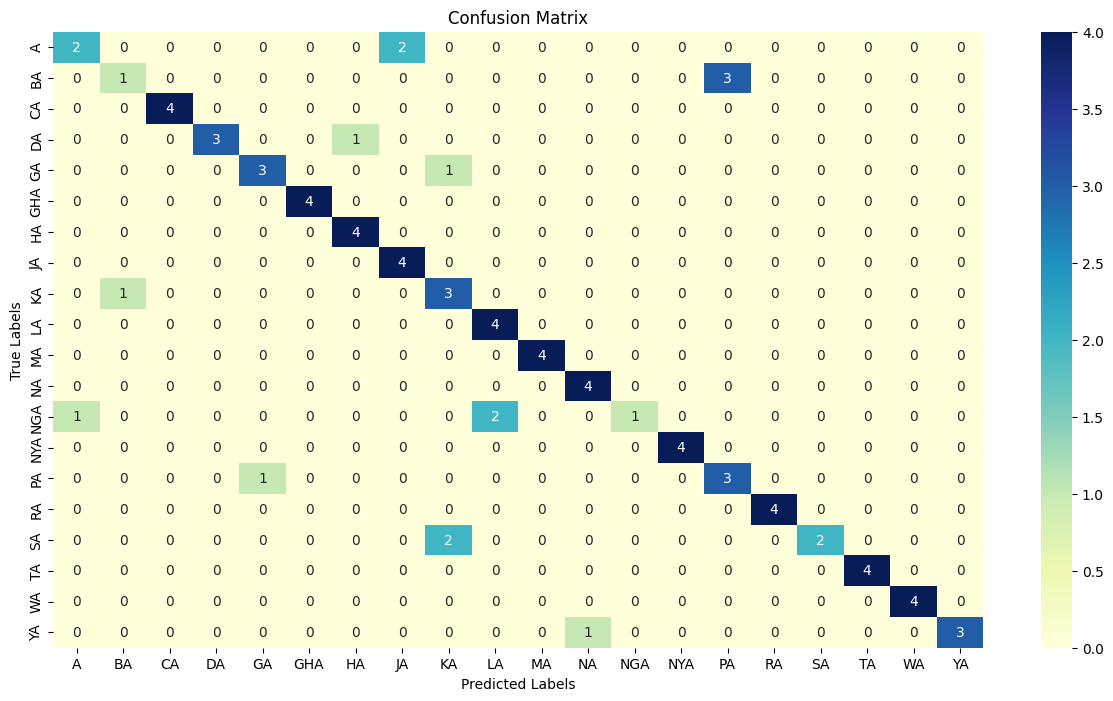

Classification Report:
              precision    recall  f1-score   support

           A       0.67      0.50      0.57         4
          BA       0.50      0.25      0.33         4
          CA       1.00      1.00      1.00         4
          DA       1.00      0.75      0.86         4
          GA       0.75      0.75      0.75         4
         GHA       1.00      1.00      1.00         4
          HA       0.80      1.00      0.89         4
          JA       0.67      1.00      0.80         4
          KA       0.50      0.75      0.60         4
          LA       0.67      1.00      0.80         4
          MA       1.00      1.00      1.00         4
          NA       0.80      1.00      0.89         4
         NGA       1.00      0.25      0.40         4
         NYA       1.00      1.00      1.00         4
          PA       0.50      0.75      0.60         4
          RA       1.00      1.00      1.00         4
          SA       1.00      0.50      0.67         4
    

In [27]:
# Reset generator
generator_test.reset()

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
predictions = vgg16_m.predict_generator(generator_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_loss, test_accuracy = vgg16_m.evaluate_generator(generator_test)

# Ubah prediksi yang diperoleh menjadi label kelas menggunakan invers dari one-hot encoding
predicted_classes = np.argmax(predictions, axis=1)
plot_confusion_matrix(classes_test, predicted_classes)

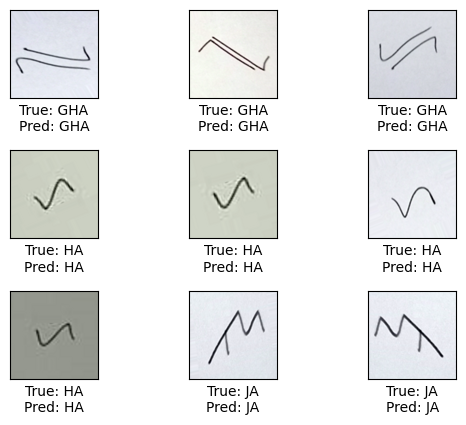

In [28]:
example_success(classes_test, predicted_classes)

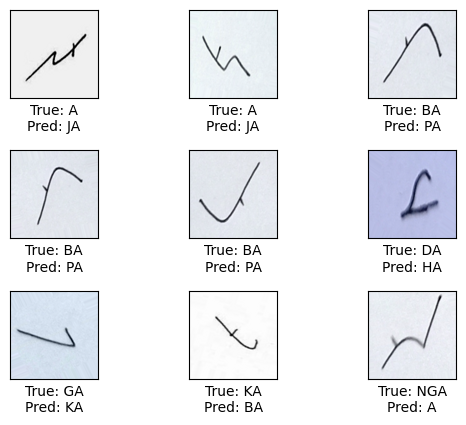

15 15


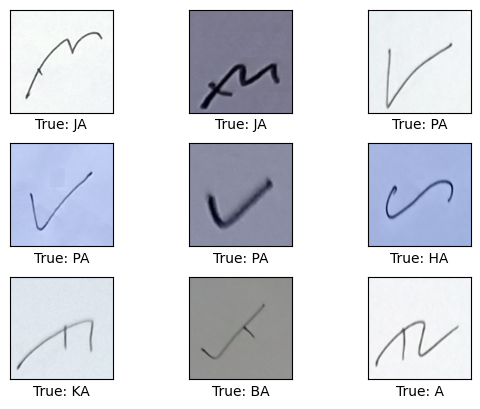

In [ ]:
example_errors(classes_test, predicted_classes)

In [30]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]
save_results(accuracy_results)

Data has been saved to ../benchmark_result/Induk aksara/results.csv


## VGG16 + Random Forest

### Features Extraction

In [31]:
X_train = vgg16_pretrained.predict(train_images)
X_val = vgg16_pretrained.predict(val_images)

# Flatten the features
X_train = X_train.reshape(X_train.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)

y_train, y_val = classes_train, classes_val

5/5 [==============================] - 0s 84ms/step


### Training the model

In [32]:
start_time = time.time()
rf_classifier = RandomForestClassifier(random_state=SEED)
rf_classifier.fit(X_train, y_train)
end_time = time.time()

### Model Evaluation

In [33]:
model_name = 'vgg16_rf_m'
model_path = f"../saved_models/{category}/{model_name}.pkl"
joblib.dump(rf_classifier, model_path)

vgg16_rf_m = joblib.load(model_path)

In [34]:
# Predictions and evaluation on training set
train_predictions = vgg16_rf_m.predict(X_train)
train_predictions_prob = vgg16_rf_m.predict_proba(X_train)

train_accuracy = accuracy_score(y_train, train_predictions)
train_loss = log_loss(y_train, train_predictions_prob)

# Predictions and evaluation on validation set
val_predictions = vgg16_rf_m.predict(X_val)
val_predictions_prob = vgg16_rf_m.predict_proba(X_val)

val_accuracy = accuracy_score(y_val, val_predictions)
val_loss = log_loss(y_val, val_predictions_prob)

print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.3706186166689432
Training Accuracy: 1.0
------------------------------------------------
Validation Loss: 1.9455229268940684
Validation Accuracy: 0.5875
------------------------------------------------
Training Times: 2.8871424198150635 seconds


### Prediction of Test Dataset

3/3 [==============================] - 0s 136ms/step
Predicting Times: 0.39516162872314453 seconds


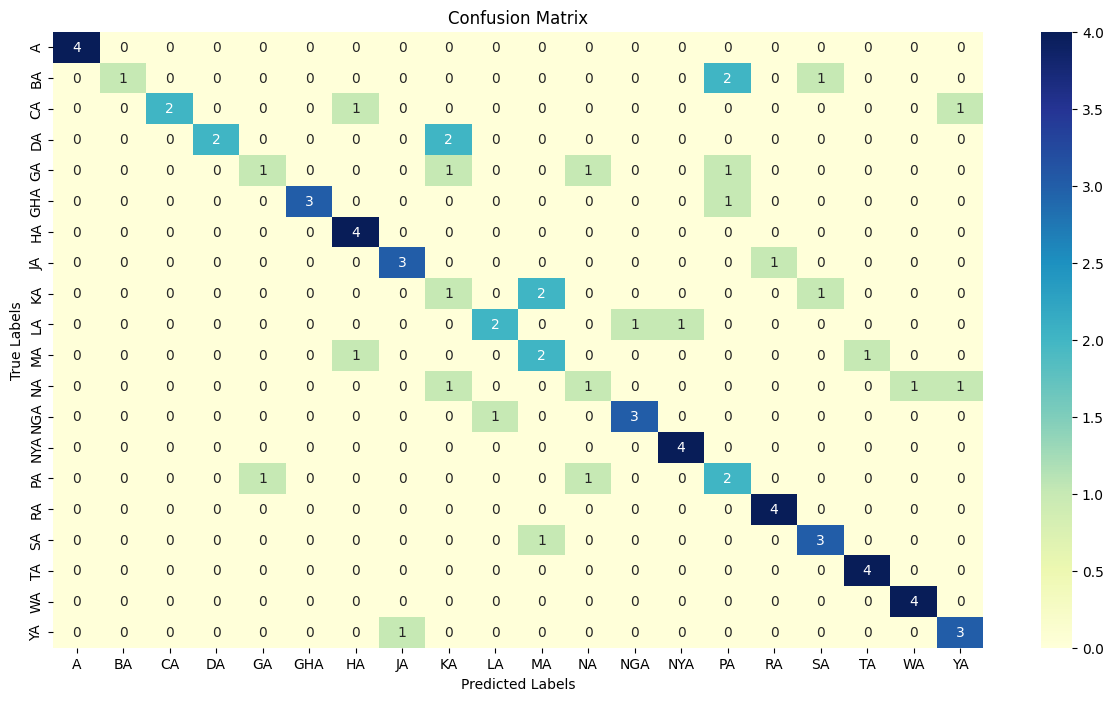

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         4
          BA       1.00      0.25      0.40         4
          CA       1.00      0.50      0.67         4
          DA       1.00      0.50      0.67         4
          GA       0.50      0.25      0.33         4
         GHA       1.00      0.75      0.86         4
          HA       0.67      1.00      0.80         4
          JA       0.75      0.75      0.75         4
          KA       0.20      0.25      0.22         4
          LA       0.67      0.50      0.57         4
          MA       0.40      0.50      0.44         4
          NA       0.33      0.25      0.29         4
         NGA       0.75      0.75      0.75         4
         NYA       0.80      1.00      0.89         4
          PA       0.33      0.50      0.40         4
          RA       0.80      1.00      0.89         4
          SA       0.60      0.75      0.67         4
    

In [35]:
y_test = classes_test

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
X_test = vgg16_pretrained.predict(test_images)
X_test = X_test.reshape(X_test.shape[0],-1)
predictions = vgg16_rf_m.predict(X_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_accuracy = accuracy_score(y_test, predictions)

plot_confusion_matrix(y_test, predictions)

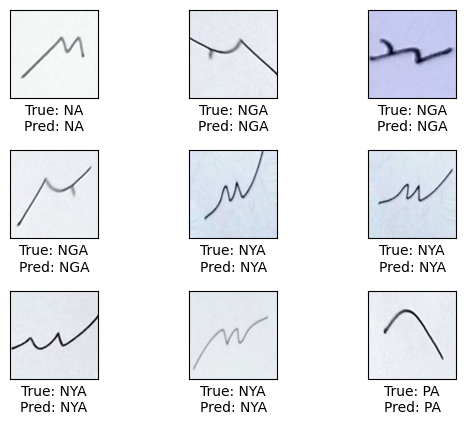

In [36]:
example_success(y_test, predictions)

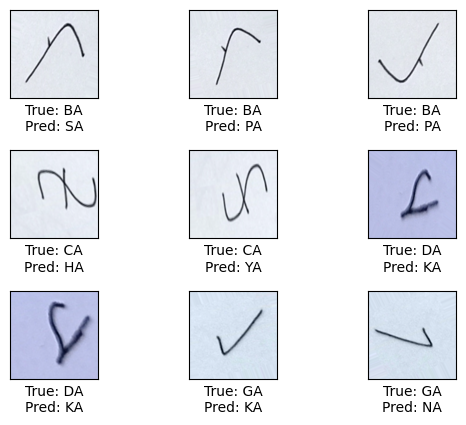

27 27


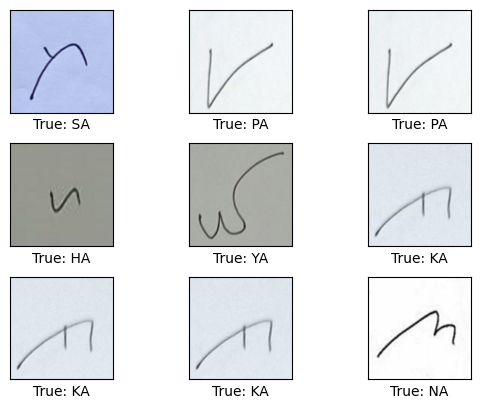

In [ ]:
example_errors(y_test, predictions)

In [38]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]
save_results(accuracy_results)

Data has been saved to ../benchmark_result/Induk aksara/results.csv


## VGG16 Tuning

### Build a Moodel

In [19]:
m = vgg16_pretrained.output
m = GlobalAveragePooling2D()(m)
m = BatchNormalization()(m)
m = Dense(512, activation='relu', name='fc1')(m)
m = Dropout(0.5)(m)
predictions = Dense(num_classes, activation='softmax', name='prediction')(m)

vgg16_tuned_m = Model(inputs=vgg16_pretrained.input, outputs=predictions, name="vgg16_tuned")

vgg16_tuned_m.summary()

Model: "vgg16_tuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       

In [20]:
for layer in vgg16_tuned_m.layers:
    layer.trainable = True

vgg16_tuned_m.summary()

Model: "vgg16_tuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       

In [21]:
print_layer_trainable(vgg16_tuned_m)

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool
True:	global_average_pooling2d
True:	batch_normalization
True:	fc1
True:	dropout
True:	prediction


In [22]:
for layer in vgg16_tuned_m.layers:
    if layer.name.startswith('block5_conv1'):
        break
    layer.trainable = False

vgg16_tuned_m.summary()

Model: "vgg16_tuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       

In [23]:
print_layer_trainable(vgg16_tuned_m)

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool
True:	global_average_pooling2d
True:	batch_normalization
True:	fc1
True:	dropout
True:	prediction


### Set Parameter Values

In [24]:
OPTIMIZER=Adam(learning_rate=0.001)
LOSS='categorical_crossentropy'
METRICS=['categorical_accuracy']

STEPS_PER_EPOCH = generator_train.n/BATCH_SIZE
VALIDATION_STEPS = generator_val.n/BATCH_SIZE
EPOCHS = 30

model_name = "vgg16_tuned_m"
filepath = f'../saved_models/{category}/{model_name}.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=2, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_categorical_accuracy', patience=7, verbose=1)

CALLBACKS = [reduce_lr, checkpoint, early_stop]

### Training the Model

In [25]:
vgg16_tuned_m.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=METRICS)

start_time = time.time()
h_vgg16_tune = vgg16_tuned_m.fit_generator(generator_train,
                                              epochs=EPOCHS, 
                                              steps_per_epoch=STEPS_PER_EPOCH, 
                                              validation_data=generator_val, 
                                              validation_steps=VALIDATION_STEPS, 
                                              callbacks=CALLBACKS)
end_time = time.time()

Epoch 1/30
17/17 [==============================] - 15s 390ms/step - loss: 2.9654 - categorical_accuracy: 0.0964 - val_loss: 36.2025 - val_categorical_accuracy: 0.0625 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - 4s 217ms/step - loss: 2.5839 - categorical_accuracy: 0.1768 - val_loss: 26.7240 - val_categorical_accuracy: 0.0500 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - 4s 229ms/step - loss: 2.2062 - categorical_accuracy: 0.2964 - val_loss: 16.4115 - val_categorical_accuracy: 0.0875 - lr: 0.0010
Epoch 4/30
17/17 [==============================] - 4s 226ms/step - loss: 1.8961 - categorical_accuracy: 0.3679 - val_loss: 10.1550 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 5/30
17/17 [==============================] - 4s 220ms/step - loss: 1.5402 - categorical_accuracy: 0.5000 - val_loss: 9.0195 - val_categorical_accuracy: 0.0500 - lr: 0.0010
Epoch 6/30
17/17 [==============================] - 4s 229ms/step - loss: 1.2923 - categorical_accur

### Model Evaluation

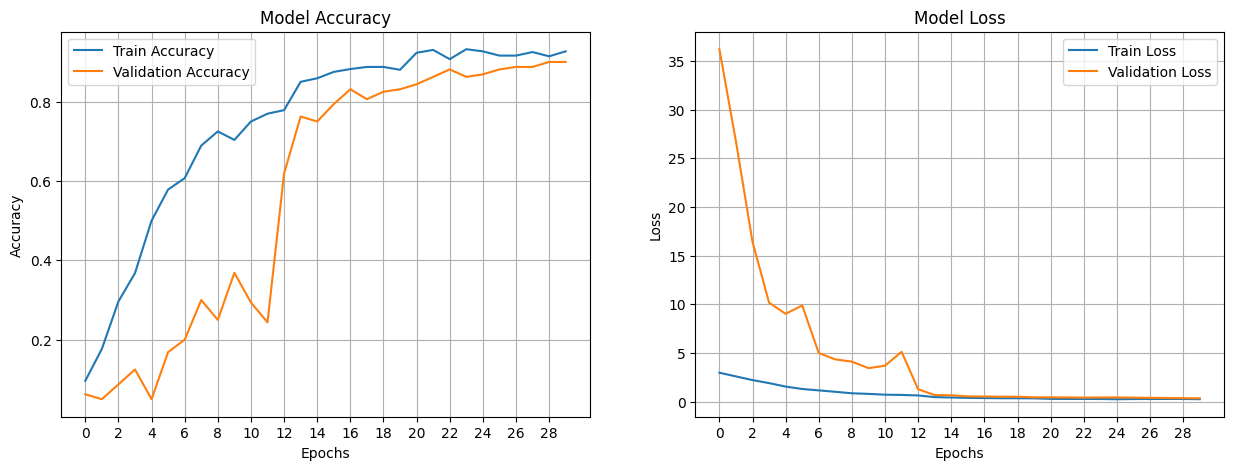

In [26]:
plot_history(h_vgg16_tune)

In [27]:
model_name = 'vgg16_tuned_m'
model_path = f"../saved_models/{category}/{model_name}.hdf5"
vgg16_tuned_m = load_model(model_path)

train_loss, train_accuracy = vgg16_tuned_m.evaluate_generator(generator_train)
print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = vgg16_tuned_m.evaluate_generator(generator_val)
print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.18513767421245575
Training Accuracy: 0.9589285850524902
------------------------------------------------
Validation Loss: 0.3502318263053894
Validation Accuracy: 0.8999999761581421
------------------------------------------------
Training Times: 130.7794964313507 seconds


### Prediction of Test Dataset

Predicting Times: 0.48572349548339844 seconds


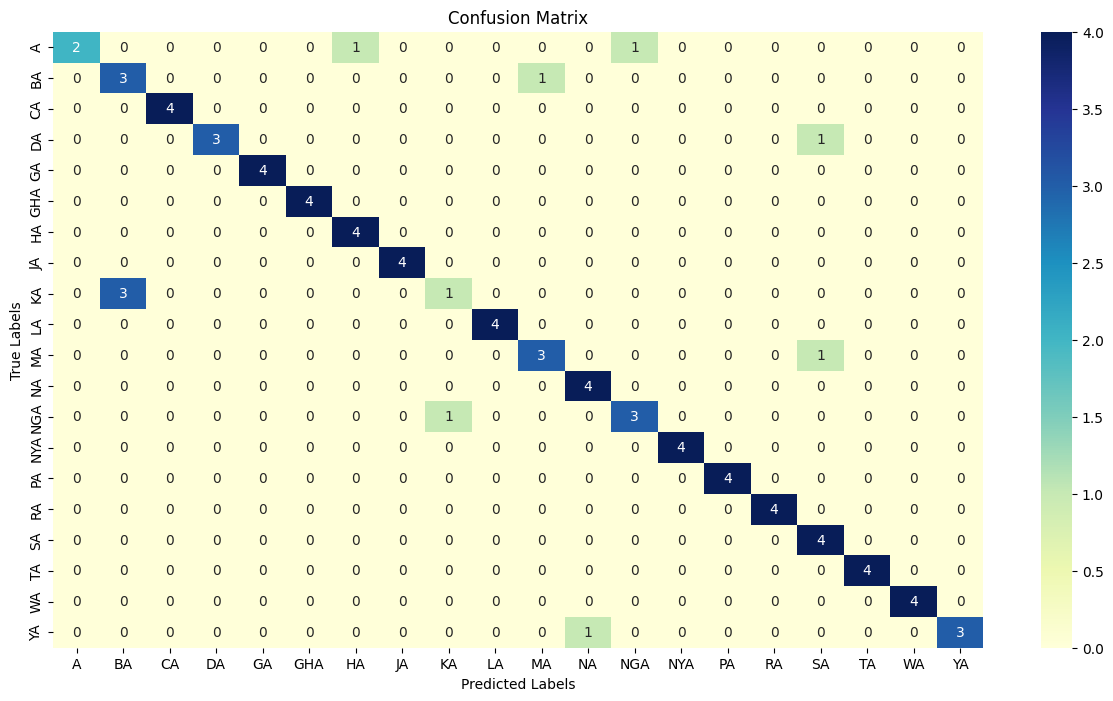

Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.50      0.67         4
          BA       0.50      0.75      0.60         4
          CA       1.00      1.00      1.00         4
          DA       1.00      0.75      0.86         4
          GA       1.00      1.00      1.00         4
         GHA       1.00      1.00      1.00         4
          HA       0.80      1.00      0.89         4
          JA       1.00      1.00      1.00         4
          KA       0.50      0.25      0.33         4
          LA       1.00      1.00      1.00         4
          MA       0.75      0.75      0.75         4
          NA       0.80      1.00      0.89         4
         NGA       0.75      0.75      0.75         4
         NYA       1.00      1.00      1.00         4
          PA       1.00      1.00      1.00         4
          RA       1.00      1.00      1.00         4
          SA       0.67      1.00      0.80         4
    

In [28]:
# Reset generator
generator_test.reset()

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
predictions = vgg16_tuned_m.predict_generator(generator_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_loss, test_accuracy = vgg16_tuned_m.evaluate_generator(generator_test)

# Ubah prediksi yang diperoleh menjadi label kelas menggunakan invers dari one-hot encoding
predicted_classes = np.argmax(predictions, axis=1)
plot_confusion_matrix(classes_test, predicted_classes)

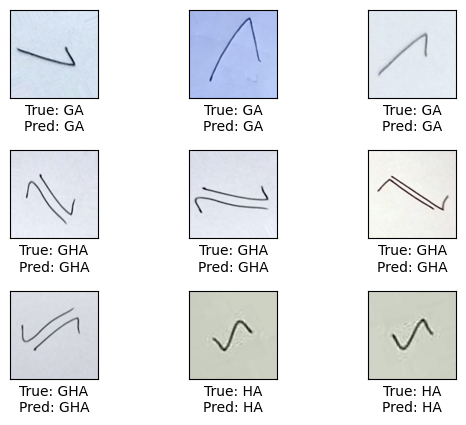

In [29]:
example_success(classes_test, predicted_classes)

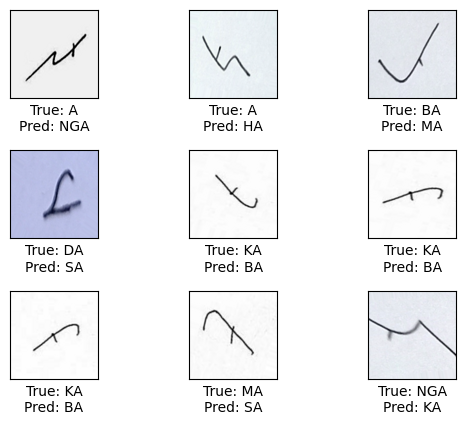

10 10


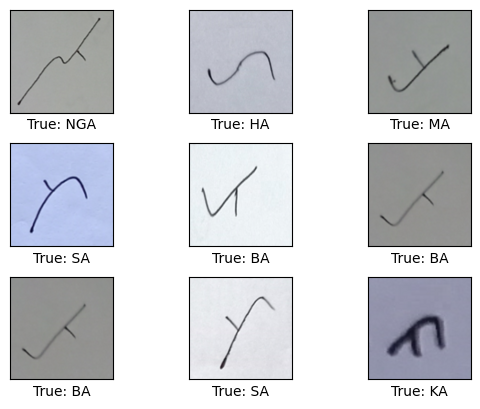

In [ ]:
example_errors(classes_test, predicted_classes)

In [31]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]
save_results(accuracy_results)

Data has been saved to ../benchmark_result/Induk aksara/results.csv


## VGG16 + Random Forest Tuning

### Build the Model for Features Extraction

In [32]:
vgg16_tuned_fe = vgg16_tuned_m.layers[-5]

vgg16_tuned_fe = Model(inputs=vgg16_tuned_m.input,
                    outputs=vgg16_tuned_fe.output)

for layer in vgg16_tuned_fe.layers:
    layer.trainable = False

vgg16_tuned_fe.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Hyperparameter Tunning GridSearchCV

In [33]:
X_train = vgg16_tuned_fe.predict(train_images)
X_val = vgg16_tuned_fe.predict(val_images)

y_train, y_val = classes_train, classes_val

5/5 [==============================] - 0s 84ms/step


In [34]:
X_train_val = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_val)], ignore_index=True).values
y_train_val = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_val)], ignore_index=True).values.reshape(-1)

params = {
    'n_estimators' : [100, 200, 300, 400]
}

gs = GridSearchCV(estimator=RandomForestClassifier(random_state=SEED),
                  param_grid=params,
                  scoring=['accuracy', 'neg_log_loss'],
                  refit='accuracy',
                  cv=5,
                  n_jobs=-1)

gs.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300, 400]},
             refit='accuracy', scoring=['accuracy', 'neg_log_loss'])

In [35]:
grid_search_results(gs)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Parameters: {'n_estimators': 100}
[CV 1/5] accuracy: (test=0.958) log_loss: (test=0.484)
[CV 2/5] accuracy: (test=0.958) log_loss: (test=0.532)
[CV 3/5] accuracy: (test=0.965) log_loss: (test=0.482)
[CV 4/5] accuracy: (test=0.951) log_loss: (test=0.414)
[CV 5/5] accuracy: (test=0.931) log_loss: (test=0.535)

Parameters: {'n_estimators': 200}
[CV 1/5] accuracy: (test=0.965) log_loss: (test=0.484)
[CV 2/5] accuracy: (test=0.951) log_loss: (test=0.531)
[CV 3/5] accuracy: (test=0.958) log_loss: (test=0.484)
[CV 4/5] accuracy: (test=0.951) log_loss: (test=0.414)
[CV 5/5] accuracy: (test=0.938) log_loss: (test=0.529)

Parameters: {'n_estimators': 300}
[CV 1/5] accuracy: (test=0.944) log_loss: (test=0.480)
[CV 2/5] accuracy: (test=0.958) log_loss: (test=0.521)
[CV 3/5] accuracy: (test=0.944) log_loss: (test=0.481)
[CV 4/5] accuracy: (test=0.958) log_loss: (test=0.417)
[CV 5/5] accuracy: (test=0.931) log_loss: (test=0.523)

Parameters

### Training the model

In [36]:
start_time = time.time()
rf_classifier = RandomForestClassifier(n_estimators=gs.best_params_['n_estimators'], random_state=SEED)
rf_classifier.fit(X_train, y_train)
end_time = time.time()

### Model Evaluation

In [37]:
model_name = 'vgg16_rf_tuned_m'
model_path = f"../saved_models/{category}/{model_name}.pkl"
joblib.dump(rf_classifier, model_path)

vgg16_rf_tuned_m = joblib.load(model_path)

In [38]:
# Predictions and evaluation on training set
train_predictions = vgg16_rf_tuned_m.predict(X_train)
train_predictions_prob = vgg16_rf_tuned_m.predict_proba(X_train)

train_accuracy = accuracy_score(y_train, train_predictions)
train_loss = log_loss(y_train, train_predictions_prob)

# Predictions and evaluation on validation set
val_predictions = vgg16_rf_tuned_m.predict(X_val)
val_predictions_prob = vgg16_rf_tuned_m.predict_proba(X_val)

val_accuracy = accuracy_score(y_val, val_predictions)
val_loss = log_loss(y_val, val_predictions_prob)

print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.1332976207900315
Training Accuracy: 1.0
------------------------------------------------
Validation Loss: 0.582055614542614
Validation Accuracy: 0.91875
------------------------------------------------
Training Times: 0.24188709259033203 seconds


### Prediction of Test Dataset

3/3 [==============================] - 0s 125ms/step
Predicting Times: 0.3954339027404785 seconds


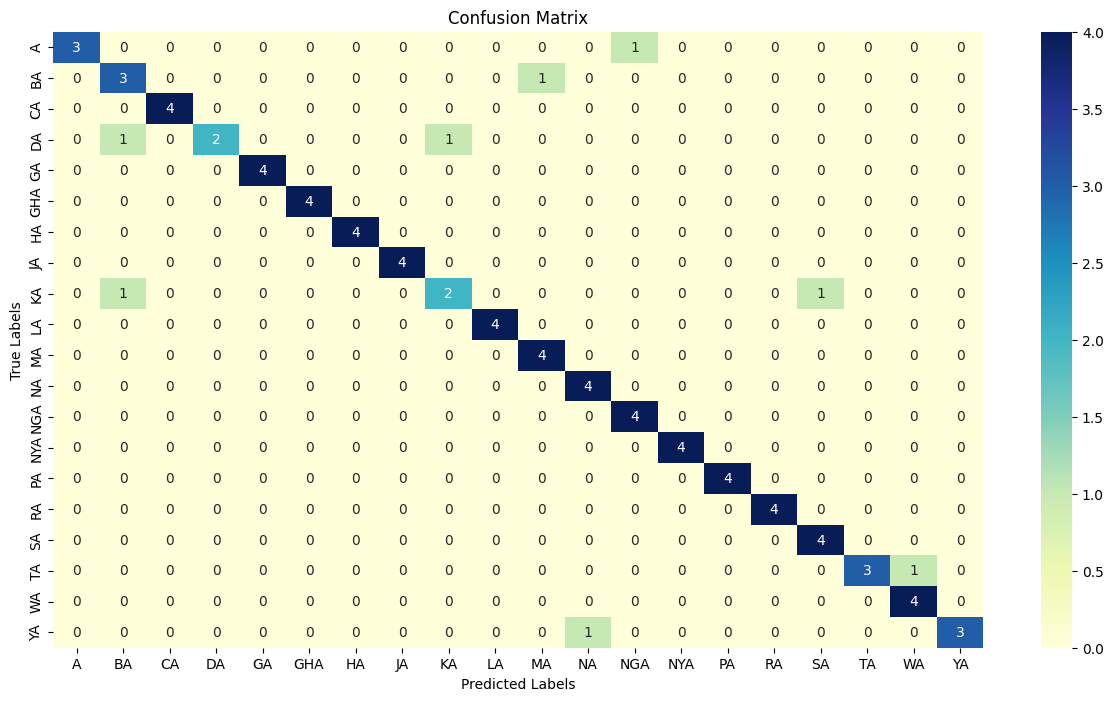

Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.75      0.86         4
          BA       0.60      0.75      0.67         4
          CA       1.00      1.00      1.00         4
          DA       1.00      0.50      0.67         4
          GA       1.00      1.00      1.00         4
         GHA       1.00      1.00      1.00         4
          HA       1.00      1.00      1.00         4
          JA       1.00      1.00      1.00         4
          KA       0.67      0.50      0.57         4
          LA       1.00      1.00      1.00         4
          MA       0.80      1.00      0.89         4
          NA       0.80      1.00      0.89         4
         NGA       0.80      1.00      0.89         4
         NYA       1.00      1.00      1.00         4
          PA       1.00      1.00      1.00         4
          RA       1.00      1.00      1.00         4
          SA       0.80      1.00      0.89         4
    

In [39]:
y_test = classes_test

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
X_test = vgg16_tuned_fe.predict(test_images)
predictions = vgg16_rf_tuned_m.predict(X_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_accuracy = accuracy_score(y_test, predictions)
plot_confusion_matrix(y_test, predictions)

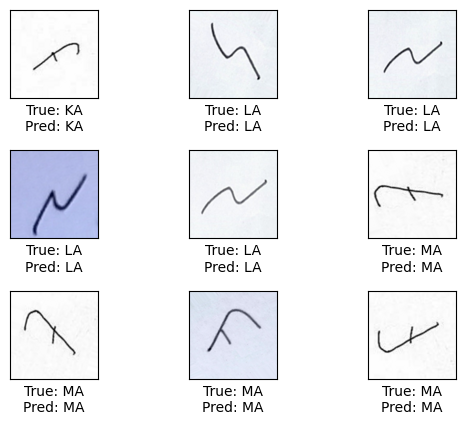

In [40]:
example_success(y_test, predictions)

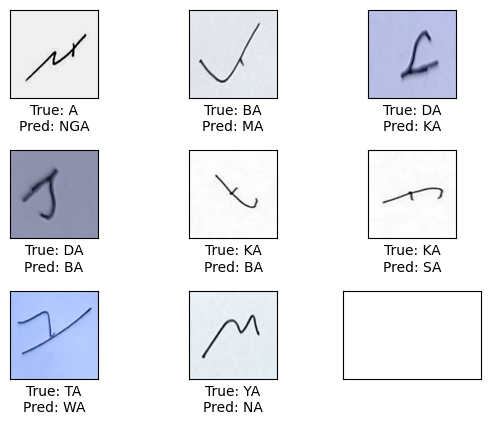

8 8


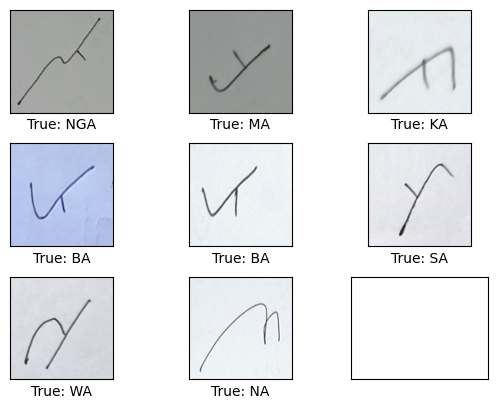

In [ ]:
example_errors(y_test, predictions)

In [42]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]
save_results(accuracy_results)

Data has been saved to ../benchmark_result/Induk aksara/results.csv


## ResNet50V2

In [44]:
resnet50_pretrained = ResNet50V2(include_top=False, 
                                 input_shape=(224, 224, 3),
                                 weights='imagenet')

resnet50_pretrained.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

### Build a Model

In [45]:
m = resnet50_pretrained.output
m = GlobalAveragePooling2D()(m)
predictions = Dense(num_classes, activation='softmax', name='prediction')(m)

resnet50_m = Model(inputs=resnet50_pretrained.input, outputs=predictions, name="resnet50")

resnet50_m.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [46]:
print_layer_trainable(resnet50_m)

True:	input_2
True:	conv1_pad
True:	conv1_conv
True:	pool1_pad
True:	pool1_pool
True:	conv2_block1_preact_bn
True:	conv2_block1_preact_relu
True:	conv2_block1_1_conv
True:	conv2_block1_1_bn
True:	conv2_block1_1_relu
True:	conv2_block1_2_pad
True:	conv2_block1_2_conv
True:	conv2_block1_2_bn
True:	conv2_block1_2_relu
True:	conv2_block1_0_conv
True:	conv2_block1_3_conv
True:	conv2_block1_out
True:	conv2_block2_preact_bn
True:	conv2_block2_preact_relu
True:	conv2_block2_1_conv
True:	conv2_block2_1_bn
True:	conv2_block2_1_relu
True:	conv2_block2_2_pad
True:	conv2_block2_2_conv
True:	conv2_block2_2_bn
True:	conv2_block2_2_relu
True:	conv2_block2_3_conv
True:	conv2_block2_out
True:	conv2_block3_preact_bn
True:	conv2_block3_preact_relu
True:	conv2_block3_1_conv
True:	conv2_block3_1_bn
True:	conv2_block3_1_relu
True:	conv2_block3_2_pad
True:	conv2_block3_2_conv
True:	conv2_block3_2_bn
True:	conv2_block3_2_relu
True:	max_pooling2d
True:	conv2_block3_3_conv
True:	conv2_block3_out
True:	conv3_bloc

In [47]:
for layer in resnet50_m.layers:
    if layer.name.startswith('global_average_pooling2d'):
        break
    layer.trainable = False

resnet50_m.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [48]:
print_layer_trainable(resnet50_m)

False:	input_2
False:	conv1_pad
False:	conv1_conv
False:	pool1_pad
False:	pool1_pool
False:	conv2_block1_preact_bn
False:	conv2_block1_preact_relu
False:	conv2_block1_1_conv
False:	conv2_block1_1_bn
False:	conv2_block1_1_relu
False:	conv2_block1_2_pad
False:	conv2_block1_2_conv
False:	conv2_block1_2_bn
False:	conv2_block1_2_relu
False:	conv2_block1_0_conv
False:	conv2_block1_3_conv
False:	conv2_block1_out
False:	conv2_block2_preact_bn
False:	conv2_block2_preact_relu
False:	conv2_block2_1_conv
False:	conv2_block2_1_bn
False:	conv2_block2_1_relu
False:	conv2_block2_2_pad
False:	conv2_block2_2_conv
False:	conv2_block2_2_bn
False:	conv2_block2_2_relu
False:	conv2_block2_3_conv
False:	conv2_block2_out
False:	conv2_block3_preact_bn
False:	conv2_block3_preact_relu
False:	conv2_block3_1_conv
False:	conv2_block3_1_bn
False:	conv2_block3_1_relu
False:	conv2_block3_2_pad
False:	conv2_block3_2_conv
False:	conv2_block3_2_bn
False:	conv2_block3_2_relu
False:	max_pooling2d
False:	conv2_block3_3_conv


### Set Parameter Values

In [49]:
OPTIMIZER=Adam(learning_rate=0.001)
LOSS='categorical_crossentropy'
METRICS=['categorical_accuracy']

STEPS_PER_EPOCH = generator_train.n/BATCH_SIZE
VALIDATION_STEPS = generator_val.n/BATCH_SIZE
EPOCHS = 30

model_name = "resnet50_m"
filepath = f'../saved_models/{category}/{model_name}.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=2, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_categorical_accuracy', patience=7, verbose=1)

CALLBACKS = [reduce_lr, checkpoint, early_stop]

### Training the Model

In [50]:
resnet50_m.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=METRICS)

start_time = time.time()
h_resnet50 = resnet50_m.fit_generator(generator_train,
                                    epochs=EPOCHS, 
                                    steps_per_epoch=STEPS_PER_EPOCH, 
                                    validation_data=generator_val, 
                                    validation_steps=VALIDATION_STEPS, 
                                    callbacks=CALLBACKS)
end_time = time.time()

Epoch 1/30
17/17 [==============================] - 7s 268ms/step - loss: 2.8754 - categorical_accuracy: 0.1518 - val_loss: 2.3924 - val_categorical_accuracy: 0.2750 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - 4s 237ms/step - loss: 2.1809 - categorical_accuracy: 0.3714 - val_loss: 1.9614 - val_categorical_accuracy: 0.4688 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - 4s 229ms/step - loss: 1.8536 - categorical_accuracy: 0.4571 - val_loss: 1.7318 - val_categorical_accuracy: 0.5500 - lr: 0.0010
Epoch 4/30
17/17 [==============================] - 4s 221ms/step - loss: 1.5752 - categorical_accuracy: 0.5429 - val_loss: 1.5558 - val_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 5/30
17/17 [==============================] - 4s 243ms/step - loss: 1.4407 - categorical_accuracy: 0.6286 - val_loss: 1.4311 - val_categorical_accuracy: 0.6687 - lr: 0.0010
Epoch 6/30
17/17 [==============================] - 4s 208ms/step - loss: 1.3274 - categorical_accuracy: 

### Model Evaluation

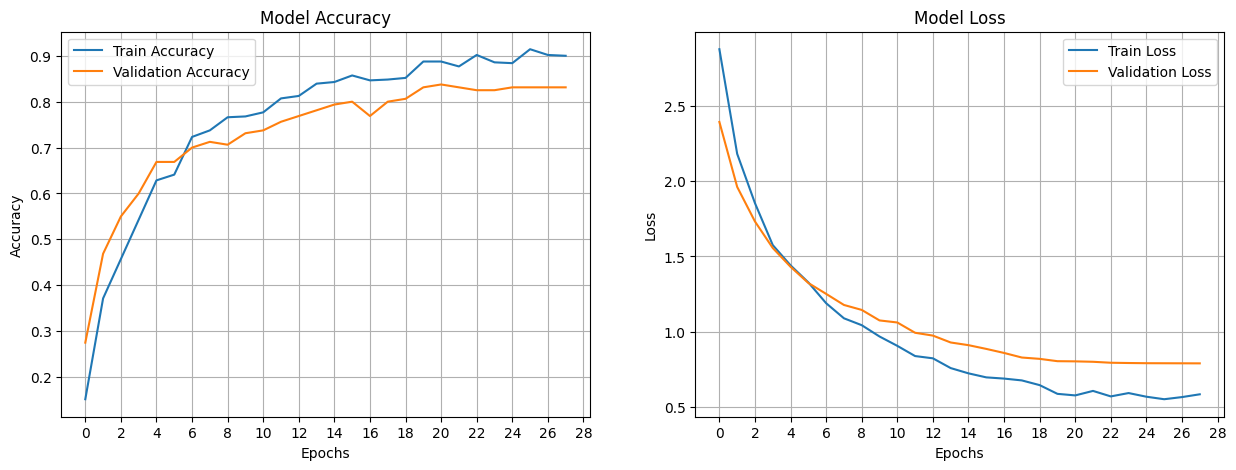

In [51]:
plot_history(h_resnet50)

In [52]:
model_name = 'resnet50_m'
model_path = f"../saved_models/{category}/{model_name}.hdf5"
resnet50_m = load_model(model_path)

train_loss, train_accuracy  = resnet50_m.evaluate_generator(generator_train)
print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = resnet50_m.evaluate_generator(generator_val)
print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.5920848846435547
Training Accuracy: 0.8803571462631226
------------------------------------------------
Validation Loss: 0.8033474087715149
Validation Accuracy: 0.8374999761581421
------------------------------------------------
Training Times: 110.31892538070679 seconds


### Prediction of Test Dataset

Predicting Times: 0.7423069477081299 seconds


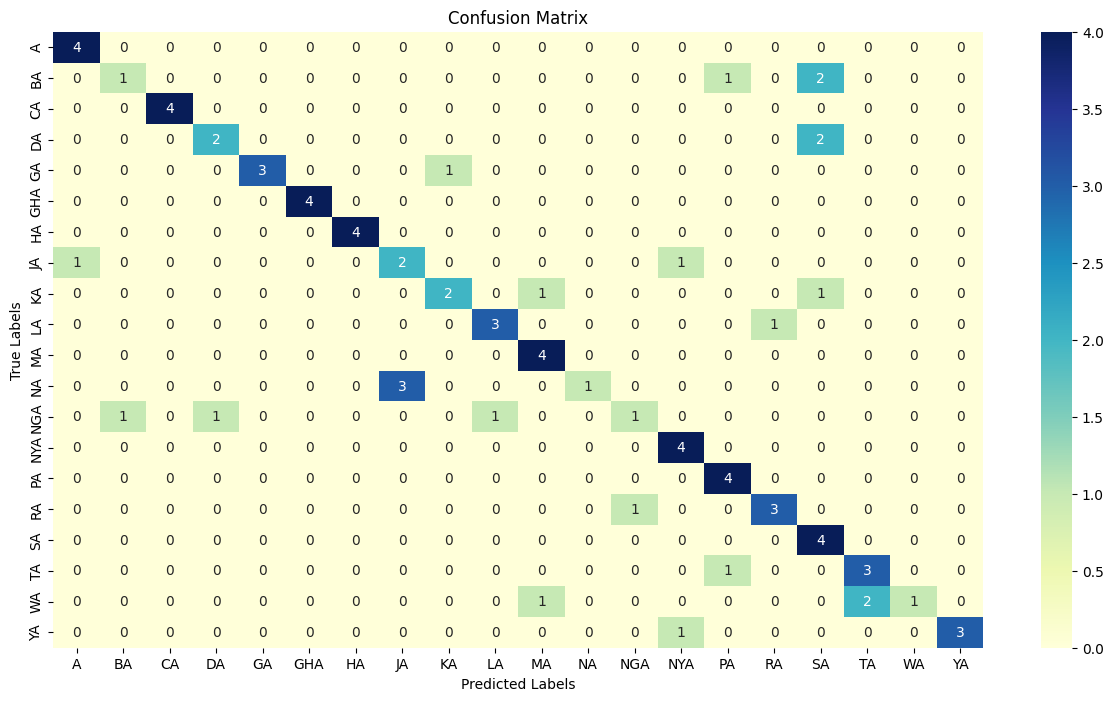

Classification Report:
              precision    recall  f1-score   support

           A       0.80      1.00      0.89         4
          BA       0.50      0.25      0.33         4
          CA       1.00      1.00      1.00         4
          DA       0.67      0.50      0.57         4
          GA       1.00      0.75      0.86         4
         GHA       1.00      1.00      1.00         4
          HA       1.00      1.00      1.00         4
          JA       0.40      0.50      0.44         4
          KA       0.67      0.50      0.57         4
          LA       0.75      0.75      0.75         4
          MA       0.67      1.00      0.80         4
          NA       1.00      0.25      0.40         4
         NGA       0.50      0.25      0.33         4
         NYA       0.67      1.00      0.80         4
          PA       0.67      1.00      0.80         4
          RA       0.75      0.75      0.75         4
          SA       0.44      1.00      0.62         4
    

In [53]:
# Reset generator
generator_test.reset()

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
predictions = resnet50_m.predict_generator(generator_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_loss, test_accuracy = resnet50_m.evaluate_generator(generator_test)

# Ubah prediksi yang diperoleh menjadi label kelas menggunakan invers dari one-hot encoding
predicted_classes = np.argmax(predictions, axis=1)
plot_confusion_matrix(classes_test, predicted_classes)

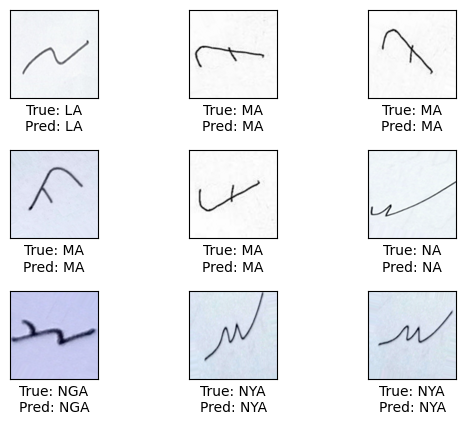

In [54]:
example_success(classes_test, predicted_classes)

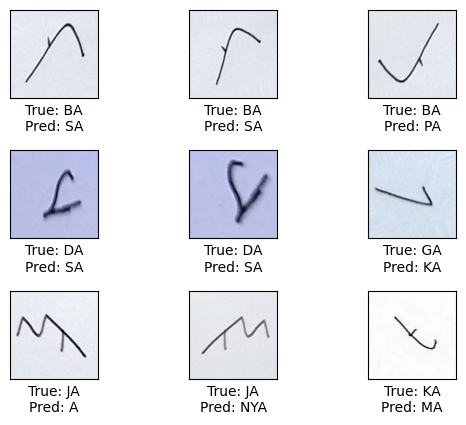

23 23


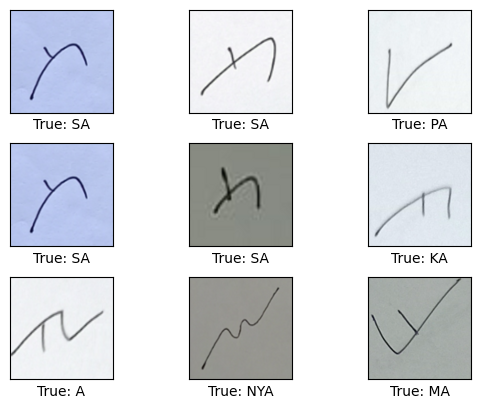

In [ ]:
example_errors(classes_test, predicted_classes)

In [56]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]
save_results(accuracy_results)

Data has been saved to ../benchmark_result/Induk aksara/results.csv


## ResNet50V2 + Random Forest

### Build the Model for Features Extraction

In [76]:
resnet50_pretrained_fe = resnet50_m.layers[-2]

resnet50_pretrained_fe = Model(inputs=resnet50_m.input,
                               outputs=resnet50_pretrained_fe.output)

for layer in resnet50_pretrained_fe.layers:
    layer.trainable = False

resnet50_pretrained_fe.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     


 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 114, 114, 64  0           ['conv1_conv[0][0]']             
                                )                                                                 
          

### Hyperparameter Tunning GridSearchCV

In [77]:
X_train = resnet50_pretrained_fe.predict(train_images)
X_val = resnet50_pretrained_fe.predict(val_images)

y_train, y_val = classes_train, classes_val

5/5 [==============================] - 0s 47ms/step


### Training the model

In [78]:
start_time = time.time()
rf_classifier = RandomForestClassifier(random_state=SEED)
rf_classifier.fit(X_train, y_train)
end_time = time.time()

### Model Evaluation

In [79]:
model_name = 'resnet50_rf_m'
model_path = f"../saved_models/{category}/{model_name}.pkl"
joblib.dump(rf_classifier, model_path)

resnet50_rf_m = joblib.load(model_path)

In [80]:
# Predictions and evaluation on training set
train_predictions = resnet50_rf_m.predict(X_train)
train_predictions_prob = resnet50_rf_m.predict_proba(X_train)

train_accuracy = accuracy_score(y_train, train_predictions)
train_loss = log_loss(y_train, train_predictions_prob)

# Predictions and evaluation on validation set
val_predictions = resnet50_rf_m.predict(X_val)
val_predictions_prob = resnet50_rf_m.predict_proba(X_val)

val_accuracy = accuracy_score(y_val, val_predictions)
val_loss = log_loss(y_val, val_predictions_prob)

print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.36087656318072503
Training Accuracy: 1.0
------------------------------------------------
Validation Loss: 1.8030330802851737
Validation Accuracy: 0.64375
------------------------------------------------
Training Times: 0.9837143421173096 seconds


### Prediction of Test Dataset

3/3 [==============================] - 0s 47ms/step
Predicting Times: 0.19310259819030762 seconds


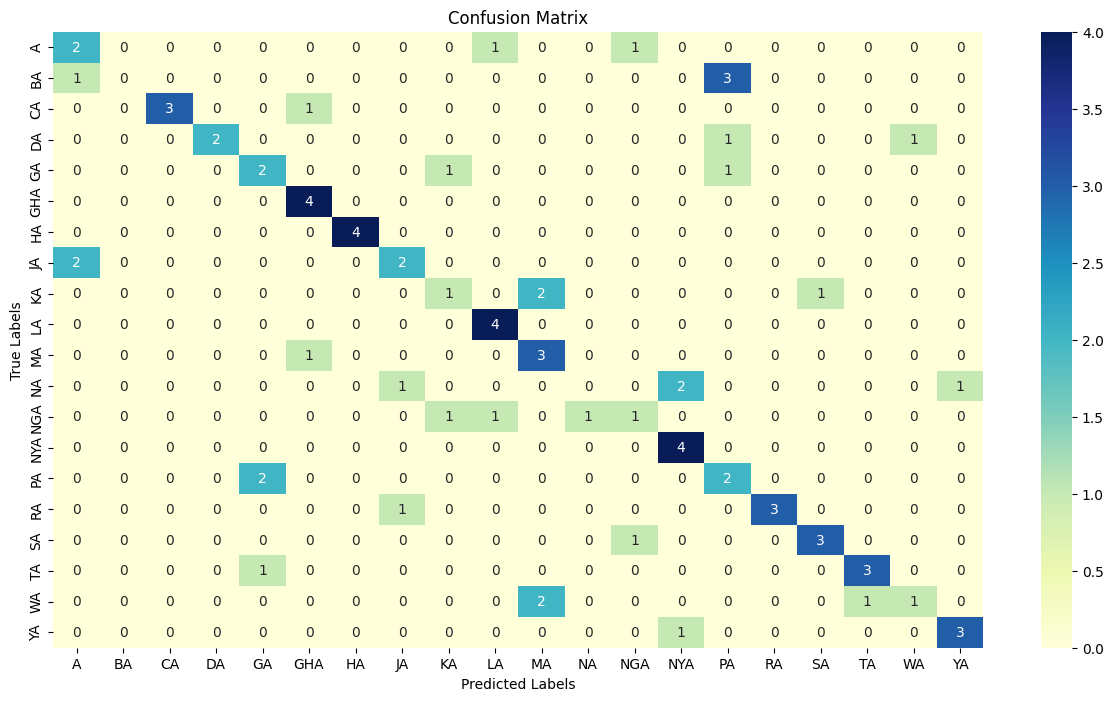

Classification Report:
              precision    recall  f1-score   support

           A       0.40      0.50      0.44         4
          BA       0.00      0.00      0.00         4
          CA       1.00      0.75      0.86         4
          DA       1.00      0.50      0.67         4
          GA       0.40      0.50      0.44         4
         GHA       0.67      1.00      0.80         4
          HA       1.00      1.00      1.00         4
          JA       0.50      0.50      0.50         4
          KA       0.33      0.25      0.29         4
          LA       0.67      1.00      0.80         4
          MA       0.43      0.75      0.55         4
          NA       0.00      0.00      0.00         4
         NGA       0.33      0.25      0.29         4
         NYA       0.57      1.00      0.73         4
          PA       0.29      0.50      0.36         4
          RA       1.00      0.75      0.86         4
          SA       0.75      0.75      0.75         4
    

In [81]:
y_test = classes_test

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
X_test = resnet50_pretrained_fe.predict(test_images)
predictions = resnet50_rf_m.predict(X_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_accuracy = accuracy_score(y_test, predictions)
plot_confusion_matrix(y_test, predictions)

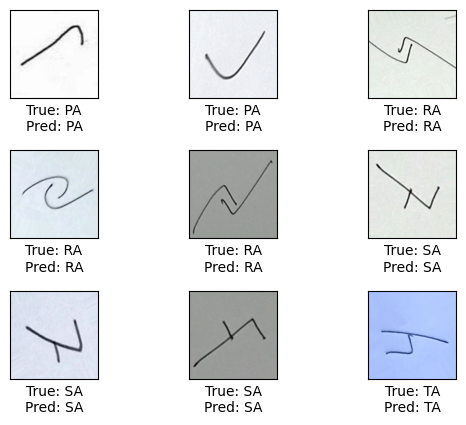

In [82]:
example_success(y_test, predictions)

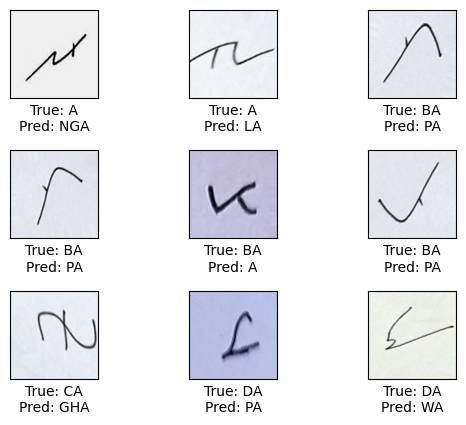

33 33


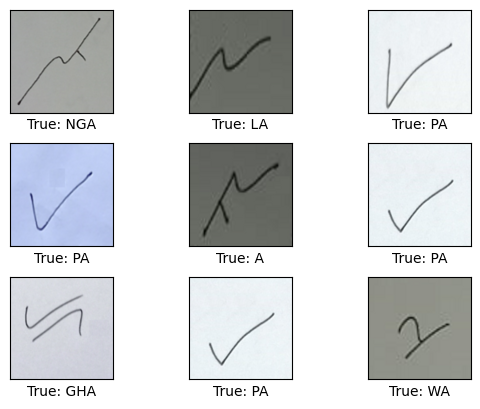

In [ ]:
example_errors(y_test, predictions)

In [84]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]
save_results(accuracy_results)

Data has been saved to ../benchmark_result/Induk aksara/results.csv


## ResNet50V2 Tuning

### Build the Model

In [85]:
m = resnet50_pretrained.output
m = GlobalAveragePooling2D()(m)
m = BatchNormalization()(m)
m = Dense(512, activation='relu', name='fc1')(m)
m = Dropout(0.5)(m)
predictions = Dense(num_classes, activation='softmax', name='prediction')(m)

resnet50_tuned_m = Model(inputs=resnet50_pretrained.input, outputs=predictions, name="resnet50_tuned")

resnet50_tuned_m.summary()

Model: "resnet50_tuned"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                     

In [86]:
for layer in resnet50_tuned_m.layers:
    layer.trainable = True

print_layer_trainable(resnet50_tuned_m)

True:	input_2
True:	conv1_pad
True:	conv1_conv
True:	pool1_pad
True:	pool1_pool
True:	conv2_block1_preact_bn
True:	conv2_block1_preact_relu
True:	conv2_block1_1_conv
True:	conv2_block1_1_bn
True:	conv2_block1_1_relu
True:	conv2_block1_2_pad
True:	conv2_block1_2_conv
True:	conv2_block1_2_bn
True:	conv2_block1_2_relu
True:	conv2_block1_0_conv
True:	conv2_block1_3_conv
True:	conv2_block1_out
True:	conv2_block2_preact_bn
True:	conv2_block2_preact_relu
True:	conv2_block2_1_conv
True:	conv2_block2_1_bn
True:	conv2_block2_1_relu
True:	conv2_block2_2_pad
True:	conv2_block2_2_conv
True:	conv2_block2_2_bn
True:	conv2_block2_2_relu
True:	conv2_block2_3_conv
True:	conv2_block2_out
True:	conv2_block3_preact_bn
True:	conv2_block3_preact_relu
True:	conv2_block3_1_conv
True:	conv2_block3_1_bn
True:	conv2_block3_1_relu
True:	conv2_block3_2_pad
True:	conv2_block3_2_conv
True:	conv2_block3_2_bn
True:	conv2_block3_2_relu
True:	max_pooling2d
True:	conv2_block3_3_conv
True:	conv2_block3_out
True:	conv3_bloc

In [87]:
for layer in resnet50_tuned_m.layers:
    if layer.name.startswith('conv5_'):
        break
    layer.trainable = False

resnet50_tuned_m.summary()

Model: "resnet50_tuned"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                     

In [88]:
print_layer_trainable(resnet50_tuned_m)

False:	input_2
False:	conv1_pad
False:	conv1_conv
False:	pool1_pad
False:	pool1_pool
False:	conv2_block1_preact_bn
False:	conv2_block1_preact_relu
False:	conv2_block1_1_conv
False:	conv2_block1_1_bn
False:	conv2_block1_1_relu
False:	conv2_block1_2_pad
False:	conv2_block1_2_conv
False:	conv2_block1_2_bn
False:	conv2_block1_2_relu
False:	conv2_block1_0_conv
False:	conv2_block1_3_conv
False:	conv2_block1_out
False:	conv2_block2_preact_bn
False:	conv2_block2_preact_relu
False:	conv2_block2_1_conv
False:	conv2_block2_1_bn
False:	conv2_block2_1_relu
False:	conv2_block2_2_pad
False:	conv2_block2_2_conv
False:	conv2_block2_2_bn
False:	conv2_block2_2_relu
False:	conv2_block2_3_conv
False:	conv2_block2_out
False:	conv2_block3_preact_bn
False:	conv2_block3_preact_relu
False:	conv2_block3_1_conv
False:	conv2_block3_1_bn
False:	conv2_block3_1_relu
False:	conv2_block3_2_pad
False:	conv2_block3_2_conv
False:	conv2_block3_2_bn
False:	conv2_block3_2_relu
False:	max_pooling2d
False:	conv2_block3_3_conv


### Set Parameter Values

In [89]:
OPTIMIZER=Adam(learning_rate=0.001)
LOSS='categorical_crossentropy'
METRICS=['categorical_accuracy']

STEPS_PER_EPOCH = generator_train.n/BATCH_SIZE
VALIDATION_STEPS = generator_val.n/BATCH_SIZE
EPOCHS = 30

model_name = "resnet50_tuned_m"
filepath = f'../saved_models/{category}/{model_name}.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=7, verbose=1)

CALLBACKS = [reduce_lr, checkpoint, early_stop]

### Training the Model

In [90]:
resnet50_tuned_m.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=METRICS)

start_time = time.time()
h_resnet50_tune = resnet50_tuned_m.fit_generator(generator_train,
                                              epochs=EPOCHS, 
                                              steps_per_epoch=STEPS_PER_EPOCH, 
                                              validation_data=generator_val, 
                                              validation_steps=VALIDATION_STEPS, 
                                              callbacks=CALLBACKS)
end_time = time.time()

Epoch 1/30
17/17 [==============================] - 8s 276ms/step - loss: 3.0047 - categorical_accuracy: 0.2446 - val_loss: 4.4690 - val_categorical_accuracy: 0.1312 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - 4s 209ms/step - loss: 1.6977 - categorical_accuracy: 0.5179 - val_loss: 9.0757 - val_categorical_accuracy: 0.1000 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - 4s 200ms/step - loss: 1.2383 - categorical_accuracy: 0.6750 - val_loss: 18.6457 - val_categorical_accuracy: 0.0750 - lr: 0.0010
Epoch 4/30
17/17 [==============================] - 4s 232ms/step - loss: 0.8268 - categorical_accuracy: 0.7661 - val_loss: 6.1904 - val_categorical_accuracy: 0.1750 - lr: 2.0000e-04
Epoch 5/30
17/17 [==============================] - 4s 237ms/step - loss: 0.5540 - categorical_accuracy: 0.8304 - val_loss: 2.6882 - val_categorical_accuracy: 0.4688 - lr: 2.0000e-04
Epoch 6/30
17/17 [==============================] - 4s 229ms/step - loss: 0.4487 - categorical_a

### Model Evaluation

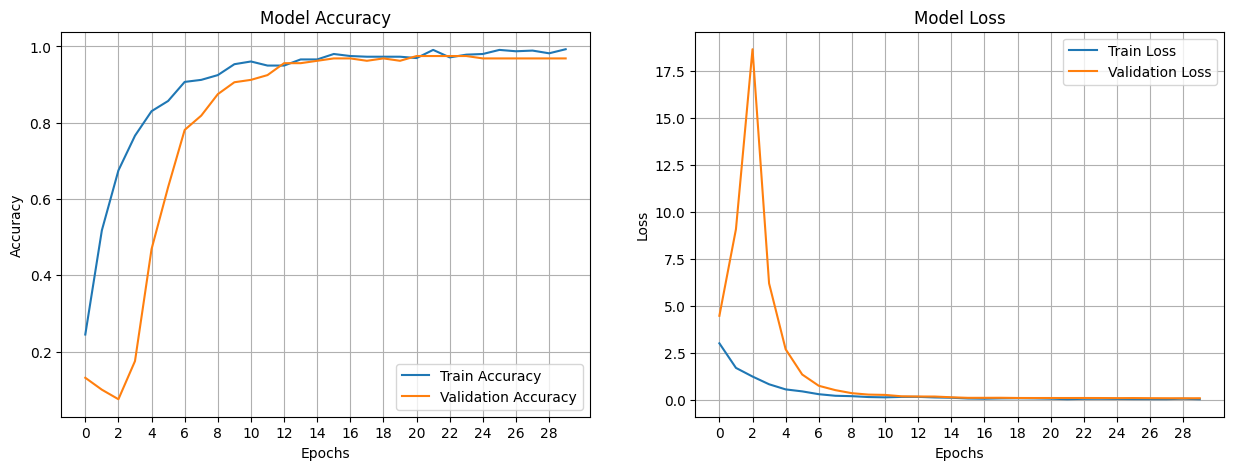

In [91]:
plot_history(h_resnet50_tune)

In [92]:
model_name = 'resnet50_tuned_m'
model_path = f"../saved_models/{category}/{model_name}.hdf5"
resnet50_tuned_m = load_model(model_path)

train_loss, train_accuracy = resnet50_tuned_m.evaluate_generator(generator_train)
print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = resnet50_tuned_m.evaluate_generator(generator_val)
print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.008180754259228706
Training Accuracy: 1.0
------------------------------------------------
Validation Loss: 0.09603739529848099
Validation Accuracy: 0.9750000238418579
------------------------------------------------
Training Times: 122.2250714302063 seconds


### Prediction of Test Dataset

Predicting Times: 0.776921272277832 seconds


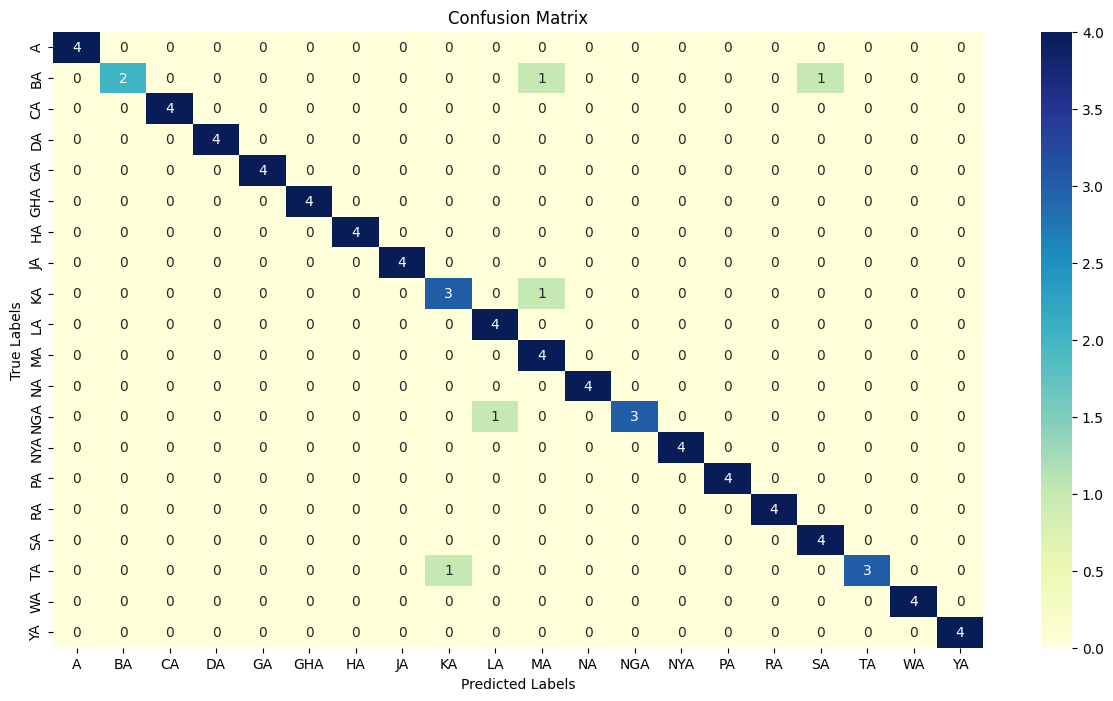

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         4
          BA       1.00      0.50      0.67         4
          CA       1.00      1.00      1.00         4
          DA       1.00      1.00      1.00         4
          GA       1.00      1.00      1.00         4
         GHA       1.00      1.00      1.00         4
          HA       1.00      1.00      1.00         4
          JA       1.00      1.00      1.00         4
          KA       0.75      0.75      0.75         4
          LA       0.80      1.00      0.89         4
          MA       0.67      1.00      0.80         4
          NA       1.00      1.00      1.00         4
         NGA       1.00      0.75      0.86         4
         NYA       1.00      1.00      1.00         4
          PA       1.00      1.00      1.00         4
          RA       1.00      1.00      1.00         4
          SA       0.80      1.00      0.89         4
    

In [93]:
# Reset generator
generator_test.reset()

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
predictions = resnet50_tuned_m.predict_generator(generator_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_loss, test_accuracy = resnet50_tuned_m.evaluate_generator(generator_test)

# Ubah prediksi yang diperoleh menjadi label kelas menggunakan invers dari one-hot encoding
predicted_classes = np.argmax(predictions, axis=1)
plot_confusion_matrix(classes_test, predicted_classes)

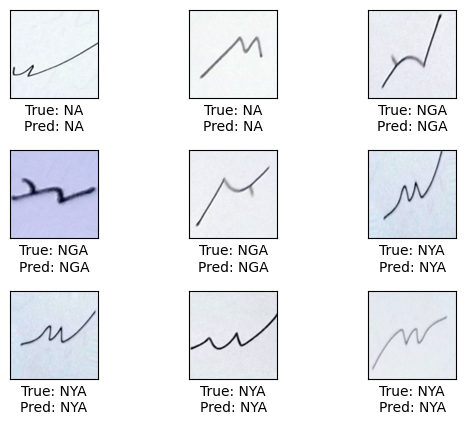

In [94]:
example_success(classes_test, predicted_classes)

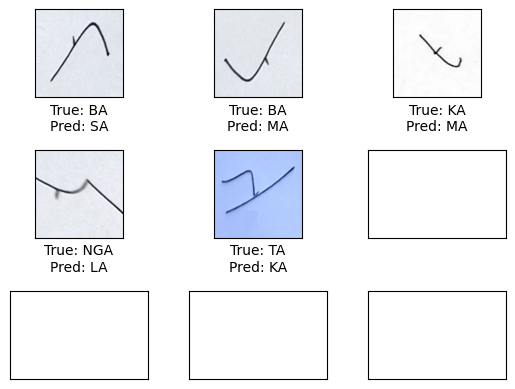

5 5


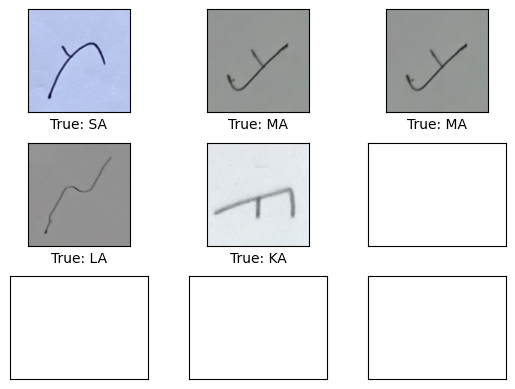

In [ ]:
example_errors(classes_test, predicted_classes)

In [96]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]
save_results(accuracy_results)

Data has been saved to ../benchmark_result/Induk aksara/results.csv


## ResNet50V2 + Random Forest Tuning

### Build the Model for Features Extraction

In [ ]:
resnet50_ft_fe = resnet50_tuned_m.layers[-5]

resnet50_ft_fe = Model(inputs=resnet50_tuned_m.input,
                  outputs=resnet50_ft_fe.output)

for layer in resnet50_ft_fe.layers:
    layer.trainable = False

resnet50_ft_fe.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4096        ['conv2_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_2_pad (ZeroPaddin  (None, 58, 58, 64)  0           ['conv2_block1_1_relu[0][0]']    
 g2D)     

### Hyperparameter Tunning GridSearchCV

In [ ]:
X_train = resnet50_ft_fe.predict(train_images)
X_val = resnet50_ft_fe.predict(val_images)
y_train, y_val = classes_train, classes_val

X_train_val = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_val)], ignore_index=True).values
y_train_val = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_val)], ignore_index=True).values.reshape(-1)

5/5 [==============================] - 0s 44ms/step


In [ ]:
params = {
    'n_estimators' : [100, 200, 300, 400],
}

gs = GridSearchCV(estimator=RandomForestClassifier(random_state=SEED),
                  param_grid=params,
                  scoring=['accuracy', 'neg_log_loss'],
                  refit='accuracy',
                  cv=5,
                  n_jobs=-1)

gs.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300, 400]},
             refit='accuracy', scoring=['accuracy', 'neg_log_loss'])

In [ ]:
grid_search_results(gs)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Parameters: {'n_estimators': 100}
[CV 1/5] accuracy: (test=0.965) log_loss: (test=0.668)
[CV 2/5] accuracy: (test=0.951) log_loss: (test=0.731)
[CV 3/5] accuracy: (test=0.958) log_loss: (test=0.733)
[CV 4/5] accuracy: (test=0.979) log_loss: (test=0.562)
[CV 5/5] accuracy: (test=0.944) log_loss: (test=0.658)

Parameters: {'n_estimators': 200}
[CV 1/5] accuracy: (test=0.958) log_loss: (test=0.669)
[CV 2/5] accuracy: (test=0.958) log_loss: (test=0.729)
[CV 3/5] accuracy: (test=0.979) log_loss: (test=0.717)
[CV 4/5] accuracy: (test=0.972) log_loss: (test=0.554)
[CV 5/5] accuracy: (test=0.958) log_loss: (test=0.643)

Parameters: {'n_estimators': 300}
[CV 1/5] accuracy: (test=0.972) log_loss: (test=0.671)
[CV 2/5] accuracy: (test=0.958) log_loss: (test=0.731)
[CV 3/5] accuracy: (test=0.979) log_loss: (test=0.717)
[CV 4/5] accuracy: (test=0.972) log_loss: (test=0.553)
[CV 5/5] accuracy: (test=0.965) log_loss: (test=0.645)

Parameters

### Training the model

In [ ]:
start_time = time.time()
rf_classifier = RandomForestClassifier(n_estimators=gs.best_params_['n_estimators'], random_state=SEED)
rf_classifier.fit(X_train, y_train)
end_time = time.time()

### Model Evaluation

In [ ]:
model_name = 'resnet50_rf_tuned_m'
model_path = f"../saved_models/{category}/{model_name}.pkl"
joblib.dump(rf_classifier, model_path)

resnet50_rf_tuned_m = joblib.load(model_path)

In [ ]:
# Predictions and evaluation on training set
train_predictions = resnet50_rf_tuned_m.predict(X_train)
train_predictions_prob = resnet50_rf_tuned_m.predict_proba(X_train)

train_accuracy = accuracy_score(y_train, train_predictions)
train_loss = log_loss(y_train, train_predictions_prob)

# Predictions and evaluation on validation set
val_predictions = resnet50_rf_tuned_m.predict(X_val)
val_predictions_prob = resnet50_rf_tuned_m.predict_proba(X_val)

val_accuracy = accuracy_score(y_val, val_predictions)
val_loss = log_loss(y_val, val_predictions_prob)

print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.17962529899294055
Training Accuracy: 1.0
------------------------------------------------
Validation Loss: 0.6830734756124112
Validation Accuracy: 0.9625
------------------------------------------------
Training Times: 4.072146415710449 seconds


### Prediction of Test Dataset

3/3 [==============================] - 0s 106ms/step
Predicting Times: 0.37342047691345215 seconds


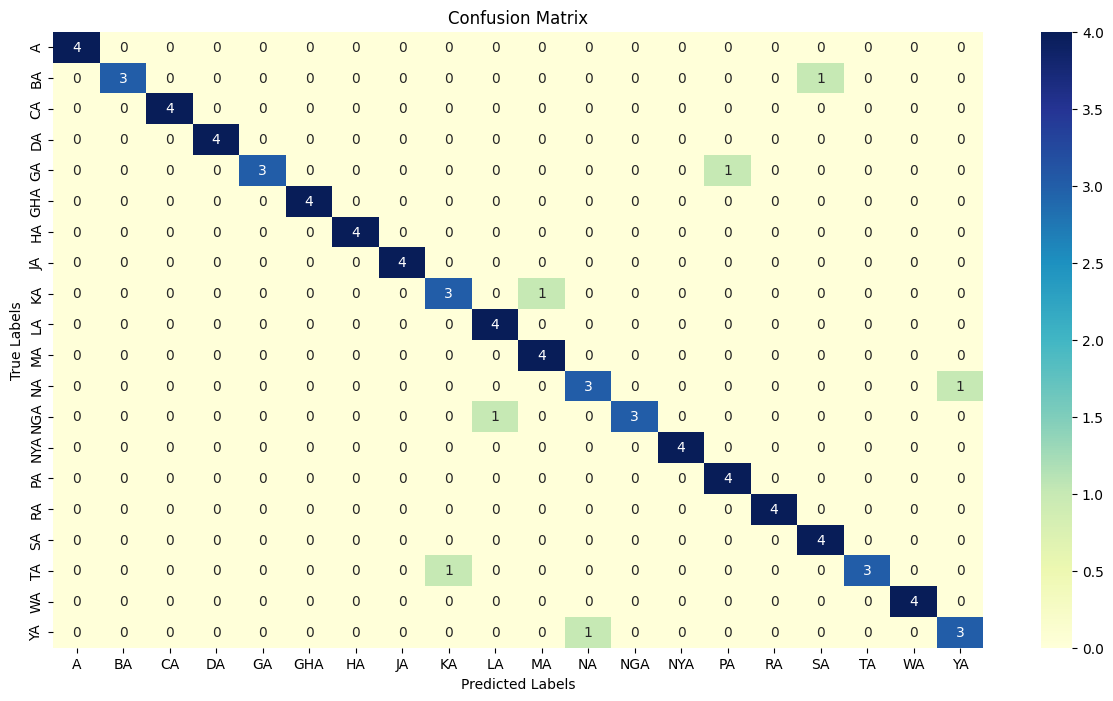

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         4
          BA       1.00      0.75      0.86         4
          CA       1.00      1.00      1.00         4
          DA       1.00      1.00      1.00         4
          GA       1.00      0.75      0.86         4
         GHA       1.00      1.00      1.00         4
          HA       1.00      1.00      1.00         4
          JA       1.00      1.00      1.00         4
          KA       0.75      0.75      0.75         4
          LA       0.80      1.00      0.89         4
          MA       0.80      1.00      0.89         4
          NA       0.75      0.75      0.75         4
         NGA       1.00      0.75      0.86         4
         NYA       1.00      1.00      1.00         4
          PA       0.80      1.00      0.89         4
          RA       1.00      1.00      1.00         4
          SA       0.80      1.00      0.89         4
    

In [ ]:
y_test = classes_test

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
X_test = resnet50_ft_fe.predict(test_images)
predictions = resnet50_rf_tuned_m.predict(X_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_accuracy = accuracy_score(y_test, predictions)

plot_confusion_matrix(y_test, predictions)

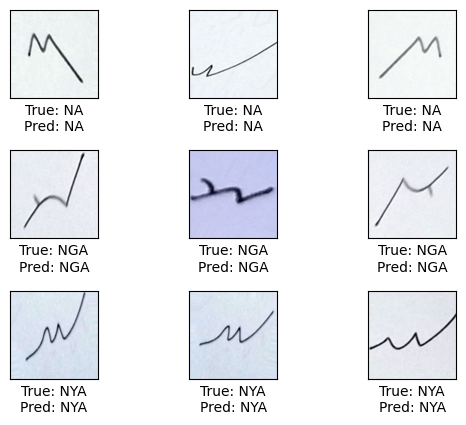

In [ ]:
example_success(y_test, predictions)

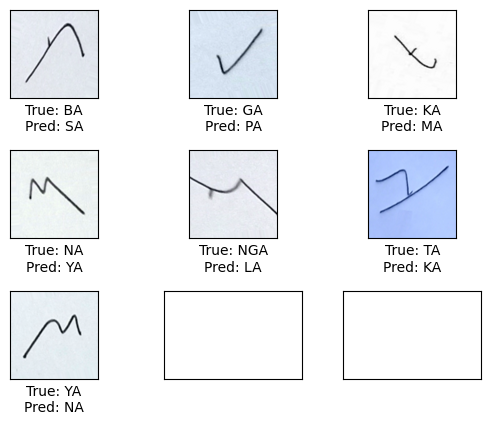

7 7


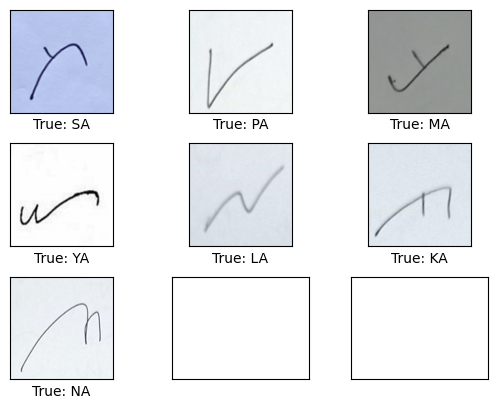

In [ ]:
example_errors(y_test, predictions)

In [ ]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]
save_results(accuracy_results)

Data has been saved to ../benchmark_result/Induk aksara/results.csv


# Benchmark All Models

In [ ]:
df = pd.read_csv(csv_file, delimiter=';')
df.round(4)

Model Name  Train Accuracy  Validation Accuracy  Test Accuracy  \
0              vgg16_m          0.9482               0.8938         0.8125   
1           vgg16_rf_m          1.0000               0.5875         0.6625   
2        vgg16_tuned_m          0.9589               0.9000         0.8750   
3     vgg16_rf_tuned_m          1.0000               0.9188         0.9000   
4           resnet50_m          0.8804               0.8375         0.7125   
5        resnet50_rf_m          1.0000               0.6438         0.5875   
6     resnet50_tuned_m          1.0000               0.9750         0.9375   
7  resnet50_rf_tuned_m          1.0000               0.9625         0.9125   

   Training Time  Predicting Time  
0       127.6362           0.5063  
1         2.8871           0.3952  
2       130.7795           0.4857  
3         0.2419           0.3954  
4       110.3189           0.7423  
5         0.9837           0.1931  
6       122.2251           0.7769  
7         4.0721           0.3734